# Data Preprocessing

The following notebook involves process of 
- Data Ingestion (Data Downloading and loading)
- Splitting data into train and test split
- Exploring data
- Preprocessing it to be fed into the model

## Importing Libraries

In [1]:
import pandas as pd
import os
import urllib.request
import pathlib
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

## Hyperparameters and global variables

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
base_path = pathlib.Path('../datasets')
file_name = 'article_category.csv'
valid_split, test_split = 0.2, 0.2
train_split = 1 - (valid_split + test_split)
seed = 42

## Loading and downloading data

In [3]:
def download_data(URL, base_path, file_name = 'dataset.csv'):
    path = base_path/file_name
    if not path.is_file():
        urllib.request.urlretrieve(URL, path)
    return path

In [4]:
data_path = download_data(DATASET_URL, base_path, file_name)
df = pd.read_csv(data_path)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [6]:
# Splitting data
train_data, valid_test_data = train_test_split(df, train_size=train_split, 
                                               random_state=seed, stratify=df['tag'])
valid_data, test_data = train_test_split(valid_test_data, train_size=valid_split/(valid_split+test_split), 
                                         random_state=seed, stratify=valid_test_data['tag'])

print(f'Number of Training samples: {len(train_data)}')
print(f'Number of Validation samples: {len(valid_data)}')
print(f'Number of Testing samples: {len(test_data)}')

Number of Training samples: 458
Number of Validation samples: 153
Number of Testing samples: 153


Verify that the distribution of output is same across the split. (This is done by specifying the stratify)

In [7]:
train_distribution = pd.DataFrame(train_data['tag'].value_counts(normalize = True)).reset_index()
train_distribution.columns = ['Tag-Category', 'Train']

valid_distribution = pd.DataFrame(valid_data['tag'].value_counts(normalize = True)).reset_index()
valid_distribution.columns = ['Tag-Category', 'valid']

test_distribution = pd.DataFrame(test_data['tag'].value_counts(normalize = True)).reset_index()
test_distribution.columns = ['Tag-Category', 'test']

In [8]:
test_distribution

,Tag-Category,test
0,natural-language-processing,0.405229
1,computer-vision,0.372549
2,other,0.137255
3,mlops,0.084967


In [9]:
all_distribution = train_distribution.join(valid_distribution.set_index('Tag-Category'), 
                                           on = 'Tag-Category').join(
                                               test_distribution.set_index('Tag-Category'), 
                                               on = 'Tag-Category')
all_distribution.head()

,Tag-Category,Train,valid,test
0,natural-language-processing,0.406114,0.405229,0.405229
1,computer-vision,0.373362,0.372549,0.372549
2,other,0.137555,0.143791,0.137255
3,mlops,0.082969,0.078431,0.084967


In [10]:
all_distribution_melt = all_distribution.melt(id_vars='Tag-Category', var_name='split')
all_distribution_melt.head()

,Tag-Category,split,value
0,natural-language-processing,Train,0.406114
1,computer-vision,Train,0.373362
2,other,Train,0.137555
3,mlops,Train,0.082969
4,natural-language-processing,valid,0.405229


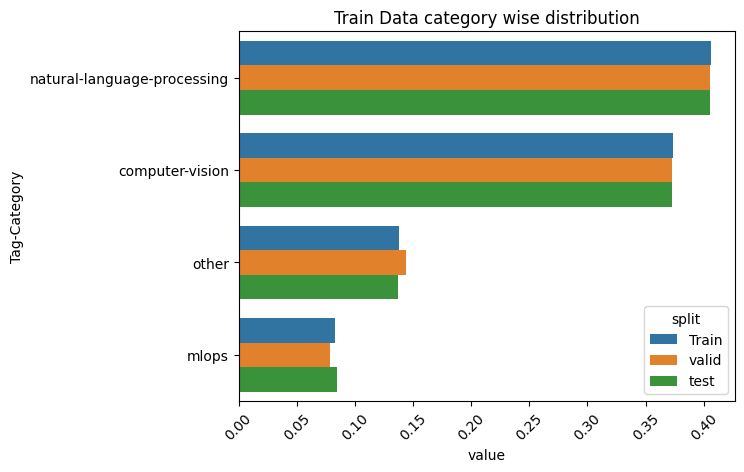

In [11]:
sns.barplot(all_distribution_melt, y = 'Tag-Category', x = 'value', hue = 'split')
plt.tick_params('x', rotation=45)
plt.title('Train Data category wise distribution');

So we can clearly see that the split result in similar distribution of each category

## EDA (Exploratory Data analysis)

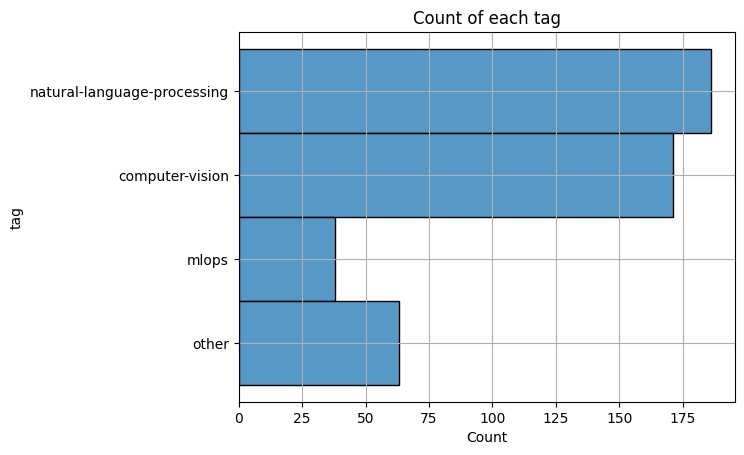

In [24]:
# Check whether the data is balanced or imbalanced
sns.histplot(train_data, y = 'tag')
plt.title('Count of each tag')
plt.grid(True);

__NOTE:__ It is clearly observable that the data is imbalanced (2 classes are dominant). This insight will help us to choose appropriate loss function and techniques to take this into account. Also, metric chosen for the task should be appropriate for assessing correct performance in this imbalanced case

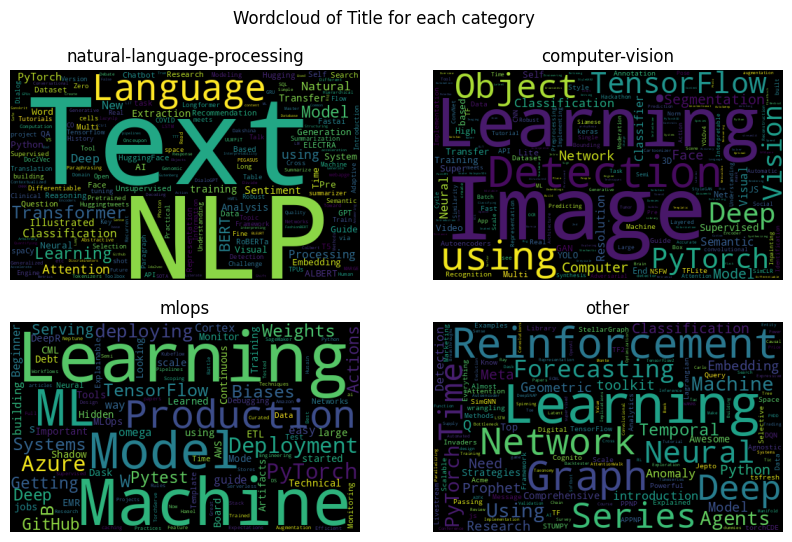

In [38]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (10,6))
plot_idx = 0
for tag in train_data['tag'].unique():
    subset = train_data[train_data['tag']==tag]
    text = subset['title'].values
    cloud = WordCloud(stopwords=STOPWORDS, collocations=False, width=500, height=300).generate(" ".join(text))
    row_num, col_num = plot_idx//2, plot_idx%2
    axes[row_num, col_num].imshow(cloud)
    axes[row_num, col_num].axis("off")
    axes[row_num, col_num].set_title(tag)
    plot_idx+=1

plt.suptitle('Wordcloud of Title for each category');

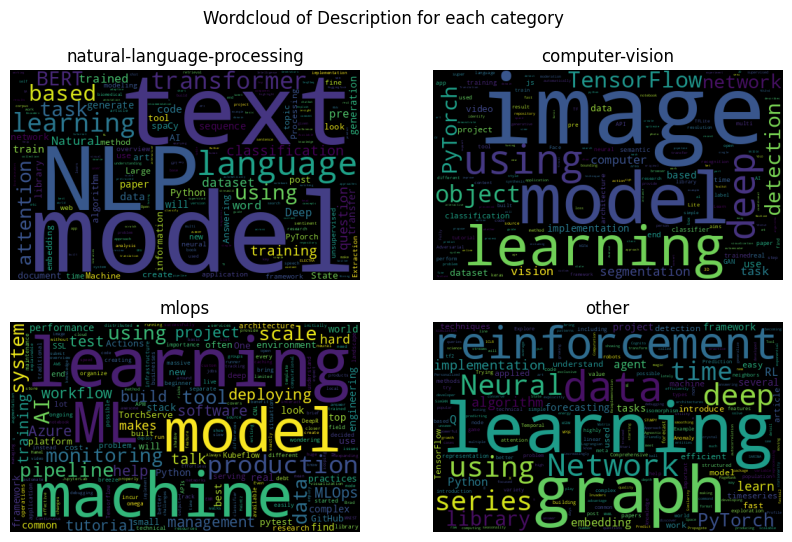

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (10,6))
plot_idx = 0
for tag in train_data['tag'].unique():
    subset = train_data[train_data['tag']==tag]
    text = subset['description'].values
    cloud = WordCloud(stopwords=STOPWORDS, collocations=False, width=500, height=300).generate(" ".join(text))
    row_num, col_num = plot_idx//2, plot_idx%2
    axes[row_num, col_num].imshow(cloud)
    axes[row_num, col_num].axis("off")
    axes[row_num, col_num].set_title(tag)
    plot_idx+=1

plt.suptitle('Wordcloud of Description for each category');

On carefully observing the wordcloud for each category, it is quiet evident that the description and title talks about something which can help us directly infer the tag from it. For eg: Natural-language-processing tags mainly talks about text, NLP, etc. which is what natural-language-processing is all about